# Lecture 9: Unconstrained optimization, Newton's method

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
import utils as utils

from func import Func
from IPython.display import display, HTML

# Inline plotting
%matplotlib inline

# Make sympy print pretty math expressions
sy.init_printing()

## Questions:

- **Homework 08:** Got stuck implementing steepest descent algorithm. How to find $\alpha_k$ using the Secant method? How to choose the two points?
- **Newton Search in nD (see below):** Tried to implement Newton's method for minimisation using solve. It gives different results than when using the inverse of Hessian. Help!
- **Newton Search in nD (see below):** When to break out of the loop for minimisation problems? When are we close to a solution?
- **Homework 09:** How to go about solving exercise 9.1 c)

---
## Newton's Method

### How does Newton's method work

Newton's method (sometimes called the Newton-Raphson method) uses first and second derivatives. The idea behind this method is as follows:

- Given a starting point $\mathbf{x}^{(k)}$, we construct a quadratic approximation $q(\mathbf{x})$ to the objective function $f(\mathbf{x})$ at that point. We can create such an approximation using the Taylor series expansion of $f$ about the point $\mathbf{x}^{(k)}$:

$$
q(\mathbf{x}) = 
    f \left(  \mathbf{x}^{(k)}  \right)
  + \left(\mathbf{x} - \mathbf{x}^{(k)} \right)^T \nabla f \left( \mathbf{x}^{(k)} \right)
  + \frac{1}{2} \left(\mathbf{x} - \mathbf{x}^{(k)} \right)^T F\left(\mathbf{x}^{(k)} \right)  \left(\mathbf{x} - \mathbf{x}^{(k)} \right)
$$
where $F$ is the Hessian.

- We then minimize the approximate (quadratic) function $q(\mathbf{x})$ instead of the original objective function $f(\mathbf{x})$.  This can be done by apply the FONC to $q$ i.e., taking the derivative of $q(\mathbf{x})$ and solving it for when $\nabla q(\mathbf{x}) = \mathbf{0}$ where $\nabla q(\mathbf{x})$ is given as:

$$
\nabla q(\mathbf{x}) = 
     \nabla f \left( \mathbf{x}^{(k)} \right)
   + F\left(\mathbf{x}^{(k)} \right)  \left(\mathbf{x} - \mathbf{x}^{(k)} \right)
$$

- We use the minimizer $\mathbf{x}^{*}$ of the approximate function as the starting point in the next step i.e., $\mathbf{x}^{(1)} = \mathbf{x}^{*}$

$$
\mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} - F \left( \mathbf{x}^{(k)} \right)^{-1} \nabla f \left( \mathbf{x}^{(k)} \right)
$$

- Repeat the procedure iteratively. 

If the objective function $f$ is quadratic, then the approximation $q$ is exact, and the method yields the true minimizer in one step. 

If, on the other hand, the objective function is not quadratic, then the approximation will provide only an estimate of the position of the true minimizer.

---
### Alternative method

<img src="figures/lecture-09/newtons-method-solve.png" width="600" />


---
### Root finding

<img src="figures/lecture-09/newtons-method-root-finding.png" width="600" />


---
## Relationship between root finding and minimisation

Newton's method can be seen as an iterative algorithm to find roots. It is often useful when a system of equations do not have a solution but we want to get close to a solution using a iterative method. For example, we know that the following problem does not have a solution:


<img src="figures/lecture-09/four-same-sized-circles-problem.png" width="400" />


This is because we cannot solve the equations with respect to all the variables i.e., we cannot find values for the variables such that all equations become true simultaneously. Solving in this regard means finding roots of system of equations. This is where Newton's method for root finding comes into the picture.

It turns out that the same idea about root finding can be applied to find the minimum of a function $f$. Instead of looking for where $f$ intersects with the $x$-axis, we look at its derivative $f'$. Basically, we try to find the root $f'$. The root of $f'$ gives us the minimum of $f$ as illustrated below:

<img src="figures/lecture-09/newton-root-to-min.png" width="400" />


Another interesting observation is that lines in the $f'$ corresponds to quadratic in $f$ as illustrated in the figure below:

<img src="figures/lecture-09/newton-approximations.png" width="400" />



On the right side, we see that Newton's method approximates a line. As lines in the $f'$ space corresponds to a quadratic function (a polynomial of degree 2) in the $f$ space, the Newton's method approximates a quadratic. The root of the line at each step in the Newton's method corresponds to the approximation of the minimum of a quadratic function.

---
### How does Newton's method compare to steepest descent method

Recall that the method of steepest descent uses only first derivatives (gradients) in selecting a suitable search direction. This strategy is not always the most effective. If higher derivatives are used, the resulting iterative algorithm may perform better than the steepest descent method. Newton's method performs better than the steepest descent method **if the initial point is close to the minimizer**.

---
### Example 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
import utils as utils

from func import Func
from IPython.display import display, HTML


# Inline plotting
%matplotlib inline

# Make sympy print pretty math expressions
sy.init_printing()

class NewtonSearch:
    def __init__(self, f: Func):
        self._f = f

    def _update_for_minimisation_using_solve(self, x_k):
        func = self._f
        x = func.get_func_args()
        
        jacob_at_x_k = func.gradient_at(x_k)
        hess_at_x_k = func.hessian_at(x_k)
        delta_x = x - x_k
        
        # Setup system of equation
        system_equation = hess_at_x_k * delta_x + jacob_at_x_k
        
        # Solve it the system of equations
        result = sy.nonlinsolve(system_equation, list(x))
        
        # Convert from set to vector
        res_vector = sy.Matrix(list(result)[0])
        
        return x_k - res_vector
        
    def _update_for_minimisation(self, x_k: sy.Matrix):
        jacob_at_x_k = self._f.gradient_at(x_k)
        hess_at_x_k = self._f.hessian_at(x_k)
        hess_inv = hess_at_x_k.inv()
        return x_k - hess_inv * jacob_at_x_k

    def _update_for_root_finding(self, x_k: sy.Matrix):
        raise Exception('Not implemented')

    def _run_algorithm(self, starting_point, epsilon, max_iterations, update_rule):
        x_k = sy.Matrix(starting_point)
        has_converged = False

        # Run iterations
        for k in range(1, max_iterations):
            
            # Apply update rule
            x_kp1 = update_rule(x_k)
            
            # Compute increment size: x(k+1) - x(k)
            increment_size = (x_kp1 - x_k).norm()
            
            # Check for convergence
            if increment_size < epsilon:
                # At this point the increment size from x(k) to x(k+1)
                # is small enough so we will stop.
                #
                # For root finding, we can stop when f(x_k) is close
                # to zero e.g. |f(x_k)| < epsilon
                has_converged = True

            # Update variables
            x_k = x_kp1
            
            print('Iteration {0:2}: step_size={1:.5f}  x({0})={2} '.format(
                k, float(increment_size), utils.format_vector(x_k) )
            )
            if has_converged:
                print(' Stopping condition reached!')
                break
        if not has_converged:
            print(' Stopping condition never reached!')

        return x_k

    def find_minimum(self, starting_point, epsilon=0.00001, max_iterations=21):
        return self._run_algorithm(
            starting_point,
            epsilon,
            max_iterations,
            self._update_for_minimisation
        )

    def find_minimum_using_solve(self, starting_point, epsilon=0.00001, max_iterations=21):
        return self._run_algorithm(
            starting_point,
            epsilon,
            max_iterations,
            self._update_for_minimisation_using_solve
        )
    
    def find_root(self, starting_point, epsilon=0.00001, max_iterations=21):
        return self._run_algorithm(
            starting_point,
            epsilon,
            max_iterations,
            self._update_for_root_finding
        )

In [3]:
x1, x2, x3, x4 = sy.symbols('x1, x2, x3, x4')
f = Func((x1 + 10*x2)**2   + 5*(x3-x4)**2  + (x2 - 2*x3)**4 + 10*(x1 - x4)**4, (x1, x2, x3, x4))
f

⎡            2               4              4              2⎤
⎣(x₁ + 10⋅x₂)  + 10⋅(x₁ - x₄)  + (x₂ - 2⋅x₃)  + 5⋅(x₃ - x₄) ⎦

In [4]:
newton_search = NewtonSearch(f)
newton_search.find_minimum_using_solve((3, -1, 0, 1))

Iteration  1: step_size=1.63515  x(1)=['1.4127', '-0.8413', '-0.2540', '0.7460'] 
Iteration  2: step_size=0.54505  x(2)=['0.8836', '-0.7884', '-0.3386', '0.6614'] 
Iteration  3: step_size=0.18168  x(3)=['0.7072', '-0.7707', '-0.3668', '0.6332'] 
Iteration  4: step_size=0.06056  x(4)=['0.6484', '-0.7648', '-0.3762', '0.6238'] 
Iteration  5: step_size=0.02019  x(5)=['0.6288', '-0.7629', '-0.3794', '0.6206'] 
Iteration  6: step_size=0.00673  x(6)=['0.6223', '-0.7622', '-0.3804', '0.6196'] 
Iteration  7: step_size=0.00224  x(7)=['0.6201', '-0.7620', '-0.3808', '0.6192'] 
Iteration  8: step_size=0.00075  x(8)=['0.6194', '-0.7619', '-0.3809', '0.6191'] 
Iteration  9: step_size=0.00025  x(9)=['0.6192', '-0.7619', '-0.3809', '0.6191'] 
Iteration 10: step_size=0.00008  x(10)=['0.6191', '-0.7619', '-0.3809', '0.6191'] 
Iteration 11: step_size=0.00003  x(11)=['0.6191', '-0.7619', '-0.3810', '0.6190'] 
Iteration 12: step_size=0.00001  x(12)=['0.6191', '-0.7619', '-0.3810', '0.6190'] 
 Stopping con

⎡  986969 ⎤
⎢ ─────── ⎥
⎢ 1594323 ⎥
⎢         ⎥
⎢-1214723 ⎥
⎢─────────⎥
⎢ 1594323 ⎥
⎢         ⎥
⎢-607360  ⎥
⎢──────── ⎥
⎢1594323  ⎥
⎢         ⎥
⎢  986963 ⎥
⎢ ─────── ⎥
⎣ 1594323 ⎦

In [5]:
newton_search = NewtonSearch(f)
newton_search.find_minimum((3, -1, 0, 1))

Iteration  1: step_size=1.82333  x(1)=['1.5873', '-0.1587', '0.2540', '0.2540'] 
Iteration  2: step_size=0.54505  x(2)=['1.0582', '-0.1058', '0.1693', '0.1693'] 
Iteration  3: step_size=0.36337  x(3)=['0.7055', '-0.0705', '0.1129', '0.1129'] 
Iteration  4: step_size=0.24224  x(4)=['0.4703', '-0.0470', '0.0752', '0.0752'] 
Iteration  5: step_size=0.16150  x(5)=['0.3135', '-0.0314', '0.0502', '0.0502'] 
Iteration  6: step_size=0.10766  x(6)=['0.2090', '-0.0209', '0.0334', '0.0334'] 
Iteration  7: step_size=0.07178  x(7)=['0.1394', '-0.0139', '0.0223', '0.0223'] 
Iteration  8: step_size=0.04785  x(8)=['0.0929', '-0.0093', '0.0149', '0.0149'] 
Iteration  9: step_size=0.03190  x(9)=['0.0619', '-0.0062', '0.0099', '0.0099'] 
Iteration 10: step_size=0.02127  x(10)=['0.0413', '-0.0041', '0.0066', '0.0066'] 
Iteration 11: step_size=0.01418  x(11)=['0.0275', '-0.0028', '0.0044', '0.0044'] 
Iteration 12: step_size=0.00945  x(12)=['0.0184', '-0.0018', '0.0029', '0.0029'] 
Iteration 13: step_size=0

⎡  52428800 ⎤
⎢───────────⎥
⎢73222472421⎥
⎢           ⎥
⎢ -5242880  ⎥
⎢───────────⎥
⎢73222472421⎥
⎢           ⎥
⎢  8388608  ⎥
⎢───────────⎥
⎢73222472421⎥
⎢           ⎥
⎢  8388608  ⎥
⎢───────────⎥
⎣73222472421⎦

---
## Nonlinear Least Squares 



---
## Levenberg-Marquardt Modification

---
### Example 9.3

In [9]:
def sinusoid(t, A, omega, phi):
    return A * np.sin(omega * t + phi)

num_points = 20
x_start = 0
x_end = 10

A = 2
omega = np.pi/4
phi = 0
noise = 0.2

# Generate data with some noise
x = np.linspace(x_start, x_end, num_points)
y_pure = sinusoid(x, A, omega, phi)
noise_data = np.random.normal(0, noise, y_pure.shape)
y = y_pure + noise_data

# Data for plotting the sinusoid
x_smooth = np.linspace(x_start, x_end, num_points*4)
y_smooth = sinusoid(x_smooth, A, omega, phi)

In [10]:
from scipy import optimize

# Use Levenberg-Marquardt algorithm for curve fitting
optimal_values, covariance = optimize.curve_fit(sinusoid, x, y)

# Generate plot data using the optimal values from the LM algorithm
fitted_A, fitted_omega, fitted_phi = optimal_values

y_fitted = sinusoid(x_smooth, fitted_A, fitted_omega, fitted_phi)

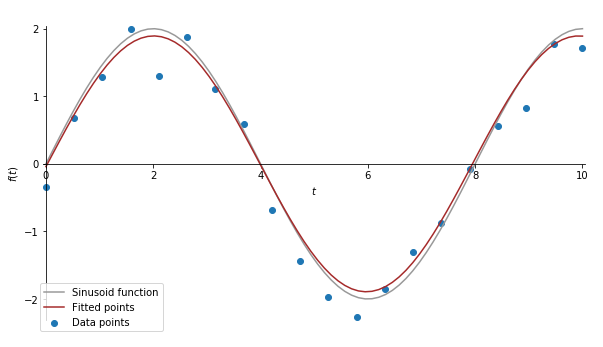

In [11]:
fig, ax = utils.prepare_plot(x, y, xlimit=(-.2, 10.2))

ax.plot(x_smooth, y_smooth, color='#999999', label='Sinusoid function')
ax.scatter(x, y, label='Data points');
ax.plot(x_smooth, y_fitted, color='brown', label='Fitted points');

ax.set_xlabel('$t$')
ax.set_ylabel('$f(t)$')
ax.legend();